# Лабораторная 3. Линейная регрессия
## Задание
- Выбор датасетов:
    - Студенты с нечетным порядковым номером в группе должны использовать про обучение студентов
1. Получите и визуалируйте (графически) статистику по датасету (включая количество, среднее значение, стандартное отклонение, минимум, максимум и разные квантили).
2. Проведите предварительно обработку данных, включая обработку отсутствующих значений, кодирование категориальных признаков и нормировка.
3. Разделите данные на обучающий и тестовый наборы данных.
4. Реализуйте линейную регрессию с использованием метода наименьших квадратов без использования сторонних библиотек, кроме NumPy и Pandas (для использования коэффициентов использовать библиотеки тоже нельзя). Использовать минимизацию суммы квадратов между фактическими и предсказанными значениями для нахождения оптимальных коэффициентов.
5. Постройте три модели с различными наборами признаков. Для каждой модели проведите оценку производительности, используя метрику коэффициент детерминации, чтобы измеритьЮ насколько хорошо модель соответствует данным.
6. Сравните результаты трех моделей и сделайте выводы о том, какие признаки работают лучше всего для каждой модели.
- Бонусное задание: Ввести синтетический признак при построении модели.
## Решение
Импортируем необходимые библиотеки:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## 1. Получите и визуализируйте (графически) статистику по набору данных (включая количество, среднее значение, стандартное отклонение, минимум, максимум и разные квантили).
Считываем данные:

In [4]:
file_path = './student_performance.csv'
data = pd.read_csv(file_path)
data

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0
...,...,...,...,...,...,...
9995,1,49,Yes,4,2,23.0
9996,7,64,Yes,8,5,58.0
9997,6,83,Yes,8,5,74.0
9998,9,97,Yes,7,0,95.0


In [5]:
data.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


Визуализируем статистику:

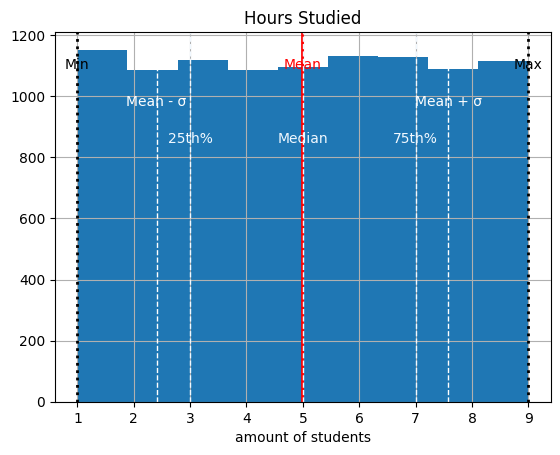

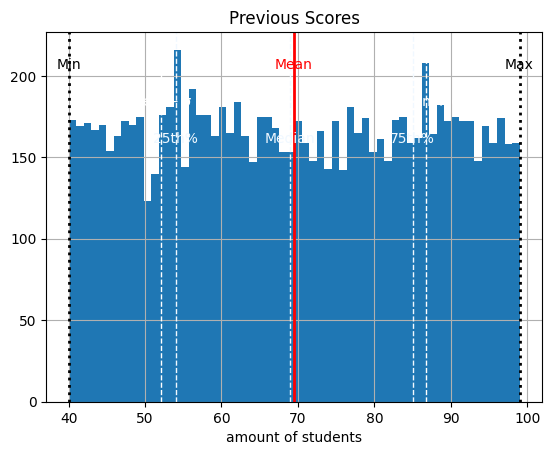

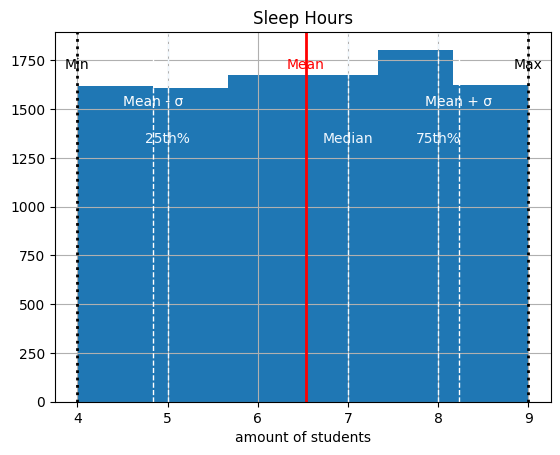

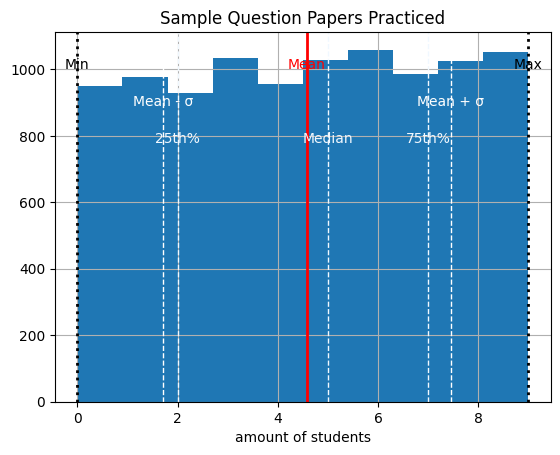

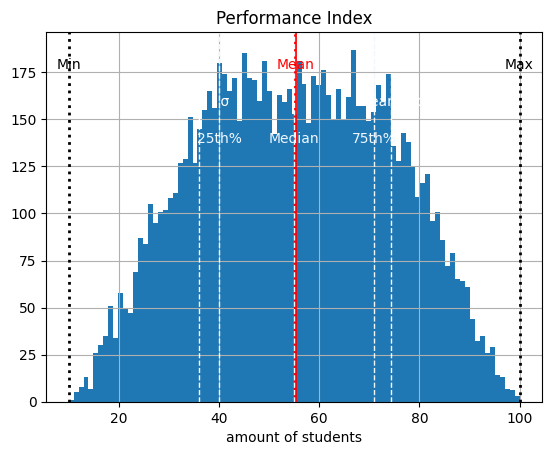

In [6]:
desc = data.describe()

for col in data.columns:
    if col == 'Extracurricular Activities':
        continue
    plt.figure()
    data[col].hist(bins=len(data[col].unique()))
    
    mean = desc[col]['mean']
    std = desc[col]['std']
    min_val = desc[col]['min']
    q25th = desc[col]['25%']
    median = desc[col]['50%']
    q75th = desc[col]['75%']
    max_val = desc[col]['max']
    
    
    plt.axvline(mean, color='r', linestyle='-', linewidth=2)
    plt.text(mean, plt.ylim()[1]*0.9, 'Mean', color='r', ha='center')
    
    plt.axvline(mean + std, color='w', linestyle='--', linewidth=1)
    plt.text(mean + std, plt.ylim()[1]*0.8, 'Mean + σ', color='w', ha='center')
    
    plt.axvline(mean - std, color='w', linestyle='--', linewidth=1)
    plt.text(mean - std, plt.ylim()[1]*0.8, 'Mean - σ', color='w', ha='center')
    
    plt.axvline(min_val, color='k', linestyle=':', linewidth=2)
    plt.text(min_val, plt.ylim()[1]*0.9, 'Min', color='k', ha='center')
    
    plt.axvline(q25th, color='aliceblue', linestyle='--', linewidth=1)
    plt.text(q25th, plt.ylim()[1]*0.7, '25th%', color='aliceblue', ha='center')
    
    plt.axvline(median, color='aliceblue', linestyle='--', linewidth=1)
    plt.text(median, plt.ylim()[1]*0.7, 'Median', color='aliceblue', ha='center')
    
    plt.axvline(q75th, color='aliceblue', linestyle='--', linewidth=1)
    plt.text(q75th, plt.ylim()[1]*0.7, '75th%', color='aliceblue', ha='center')
    
    plt.axvline(max_val, color='k', linestyle=':', linewidth=2)
    plt.text(max_val, plt.ylim()[1]*0.9, 'Max', color='k', ha='center')
    
    plt.xlabel('amount of students')
    plt.title(col)
    plt.show()

## 2. Проведите предварительную обработку данных, включая обработку отсутствующих значений, кодирование категориальных признаков и нормировка.
Удаляем строки с пропущенными занятиями:

In [8]:
missing_values = data.isnull().sum()
print("Отсутствующие значения в каждом колонне:")
print(missing_values)
deleted_rows = data.isnull().any(axis=1).sum()
data = data.dropna()
print("Удаленные строки:", deleted_rows)

Отсутствующие значения в каждом колонне:
Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64
Удаленные строки: 0


Потом, кодируем категориальные признаки:

In [9]:
data['Extracurricular Activities'] = data['Extracurricular Activities'].map({'Yes': 1, 'No': 0})
data

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0
...,...,...,...,...,...,...
9995,1,49,1,4,2,23.0
9996,7,64,1,8,5,58.0
9997,6,83,1,8,5,74.0
9998,9,97,1,7,0,95.0


Затем нормируем данные. По формуле он выглядит так:\
$x'_i = \frac{x_i - min(x)}{max(x) - min(x)}$


In [10]:
data = (data - data.min()) / (data.max() - data.min())
data

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,0.750,1.000000,1.0,1.0,0.111111,0.900000
1,0.375,0.711864,0.0,0.0,0.222222,0.611111
2,0.875,0.186441,1.0,0.6,0.222222,0.388889
3,0.500,0.203390,1.0,0.2,0.222222,0.288889
4,0.750,0.593220,0.0,0.8,0.555556,0.622222
...,...,...,...,...,...,...
9995,0.000,0.152542,1.0,0.0,0.222222,0.144444
9996,0.750,0.406780,1.0,0.8,0.555556,0.533333
9997,0.625,0.728814,1.0,0.8,0.555556,0.711111
9998,1.000,0.966102,1.0,0.6,0.000000,0.944444


In [22]:
data.describe()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index,Preparation,Time Left
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04
mean,0.499113,0.499080,0.494800,0.506120,0.509256,0.502498,0.255976,2.843947e-16
std,0.323664,0.293952,0.499998,0.339173,0.318594,0.213473,0.252859,1.000000e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.089016e+00
25%,0.250000,0.237288,0.000000,0.200000,0.222222,0.333333,0.041667,-7.959679e-01
50%,0.500000,0.491525,0.000000,0.600000,0.555556,0.500000,0.166667,-1.494440e-01
75%,0.750000,0.762712,1.000000,0.800000,0.777778,0.677778,0.416667,8.203418e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.113390e+00


## 3. Разделите данные на обучающий и тестовый наборы данных.
Данные разделены так:
- 80% $\textemdash$ обучающая выборка;
- 20% $\textemdash$ тестовая выборка:

In [13]:
x = data[['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced']].values
y = data['Performance Index'].values

x = np.concatenate([np.ones((x.shape[0], 1)), x], axis = 1)

training_set_size = int(0.8 * x.shape[0])
x_training_set, x_testing_set = x[:training_set_size], x[training_set_size:]
y_training_set, y_testing_set = y[:training_set_size], y[training_set_size:]

x_training_set.shape, x_testing_set.shape, y_training_set.shape, y_testing_set.shape

((8000, 6), (2000, 6), (8000,), (2000,))

## 4. Реализуйте линейную регрессию с использованием метода наименьших квадратов без использования сторонних библиотек, кроме NumPy и Pandas (для использования коэффициентов использовать библиотеки тоже нельзя). Использовать минимизацию суммы квадратов разностей между фактическими и предсказанными значениями для нахождения оптимальных коэффициентов.
Реализуем функцию для градиентного спуска

In [15]:
def gradient_descent(x, y, theta, learning_rate=0.01, iterations=1000):
    assert x.shape[0] == y.shape[0]
    assert x.shape[1] == theta.shape[0]
    print(f"Training {iterations} iterations with learning rate {learning_rate}")
    m = len(y)
    for i in range(iterations):
        predictions = x.dot(theta)
        gradients = (1 / m) * x.T.dot(predictions - y)
        theta -= learning_rate * gradients
        
        if i % 100 == 0 or i == iterations - 1:
            cost = (1 / (2 * m)) * np.sum((predictions - y) ** 2)
            print(f"Iteration {i}: Cost ({cost})")
    print("Training finished.")
    return theta

theta = np.zeros(x_testing_set.shape[1])

theta = gradient_descent(x_testing_set, y_testing_set, theta)

theta

Training 1000 iterations with learning rate 0.01
Iteration 0: Cost (0.15004382716049383)
Iteration 100: Cost (0.01501893951353324)
Iteration 200: Cost (0.011585947973668428)
Iteration 300: Cost (0.009710464378048279)
Iteration 400: Cost (0.008197112368028628)
Iteration 500: Cost (0.006959336187552984)
Iteration 600: Cost (0.00593946076358353)
Iteration 700: Cost (0.005093888046153689)
Iteration 800: Cost (0.0043890900929418955)
Iteration 900: Cost (0.0037989132948972847)
Iteration 999: Cost (0.0033072550358476532)
Training finished.


array([0.16653084, 0.18410228, 0.41400636, 0.0103129 , 0.03493031,
       0.04135945])

## 5. Постройте три модели с различными наборами признаков. Для каждой модели проведите оценку производительности, используя метрику коэффициент детерминации, чтобы измерить, насколько хорошо модель соответствует данным.
Функция для вычисления коэффициента детерминации:

In [17]:
def r_sqr2(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    mean_y = np.mean(y_true)
    tss = np.sum((y_true - mean_y) ** 2)
    rss = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (rss / tss)
    return r2

### Модель 1: все признаки

In [18]:
x_training_set_model, x_testing_set_model = x_training_set, x_testing_set
theta_model = np.zeros(x_training_set_model.shape[1])
theta_model = gradient_descent(x_training_set_model, y_training_set, theta_model)
y_pred_model = x_testing_set_model.dot(theta_model)
r2_model = r_sqr2(y_testing_set, y_pred_model)
r2_model

Training 1000 iterations with learning rate 0.01
Iteration 0: Cost (0.14878287037037036)
Iteration 100: Cost (0.015059241002806183)
Iteration 200: Cost (0.011541159131640246)
Iteration 300: Cost (0.009662896060716814)
Iteration 400: Cost (0.008154874718814365)
Iteration 500: Cost (0.006924597941090517)
Iteration 600: Cost (0.005911992344541394)
Iteration 700: Cost (0.005072404070161635)
Iteration 800: Cost (0.004371981132206777)
Iteration 900: Cost (0.0037846238654025035)
Iteration 999: Cost (0.0032944470303623513)
Training finished.


np.float64(0.8539448275980489)

### Модель 2: признаки 'Hours Studied', 'Hours Slept':

In [19]:
x_training_set_model_2, x_testing_set_model_2 = x_training_set_model[:, [0, 1, 4]], x_testing_set_model[:, [0, 1, 4]]
theta_model_2 = np.zeros(x_training_set_model_2.shape[1])
theta_model_2 = gradient_descent(x_training_set_model_2, y_training_set, theta_model_2)
y_pred_model_2 = x_testing_set_model_2.dot(theta_model_2)
r2_model_2 = r_sqr2(y_testing_set, y_pred_model_2)
r2_model_2

Training 1000 iterations with learning rate 0.01
Iteration 0: Cost (0.14878287037037036)
Iteration 100: Cost (0.026444855557533287)
Iteration 200: Cost (0.02075793232730364)
Iteration 300: Cost (0.02033148870938753)
Iteration 400: Cost (0.02017388941811207)
Iteration 500: Cost (0.0200552651506619)
Iteration 600: Cost (0.019960066629385417)
Iteration 700: Cost (0.019883364855391224)
Iteration 800: Cost (0.019821535186447872)
Iteration 900: Cost (0.019771677770284723)
Iteration 999: Cost (0.019731821774513946)
Training finished.


np.float64(0.12129685811134738)

### Модель 3: признаки 'Previous Scores', 'Extracurricular Activities', 'Sample Question Papers Practiced':

In [20]:
x_training_set_model_3, x_testing_set_model_3 = x_training_set_model[:, [0, 2, 3, 5]], x_testing_set_model[:, [0, 2, 3, 5]]
theta_model_3 = np.zeros(x_training_set_model_3.shape[1])
theta_model_3 = gradient_descent(x_training_set_model_3, y_training_set, theta_model_3)
y_pred_model_3 = x_testing_set_model_3.dot(theta_model_3)
r2_model_3 = r_sqr2(y_testing_set, y_pred_model_3)
r2_model_3

Training 1000 iterations with learning rate 0.01
Iteration 0: Cost (0.14878287037037036)
Iteration 100: Cost (0.01915092916793728)
Iteration 200: Cost (0.013568363885324168)
Iteration 300: Cost (0.011678706829044356)
Iteration 400: Cost (0.010263276512057296)
Iteration 500: Cost (0.009141922349011865)
Iteration 600: Cost (0.008241002613993693)
Iteration 700: Cost (0.007509167901999356)
Iteration 800: Cost (0.00690907814197257)
Iteration 900: Cost (0.006413095595662958)
Iteration 999: Cost (0.006004187710316485)
Training finished.


np.float64(0.7363527235857688)

### Бонусная модель: добавление синтетических признаков:
'Preparation' == 'Hours Studied' * 'Sample Question Papers Practiced';\
'Time Left' == 24 (часов) - ('Sleep Hours' + 'Hours Studied'):

In [1]:
data['Preparation'] = data['Hours Studied'] * data ['Sample Question Papers Practiced']
initial_data = pd.read_csv('./student_performance.csv')
data['Time Left'] = 24 - (initial_data['Sleep Hours'] + initial_data['Hours Studied'])
data['Time Left'] = (data['Time Left'] - data['Time Left'].mean()) / data['Time Left'].std()
data

NameError: name 'data' is not defined

In [26]:
x_synth = data[['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced', 'Preparation', 'Time Left']].values
x_synth = np.concatenate([np.ones((x_synth.shape[0], 1)), x_synth], axis=1)

training_set_size = int(0.8 * x_synth.shape[0])
x_training_set_synth, x_testing_set_synth = x_synth[:training_set_size], x_synth[training_set_size:]
y_training_set_synth, y_testing_set_synth = y[:training_set_size], y[training_set_size:]

x_training_set_synth.shape, x_testing_set_synth.shape, y_training_set_synth.shape, y_testing_set_synth.shape

((8000, 8), (2000, 8), (8000,), (2000,))

### Модель №4: все признаки + синтетический признак:

In [29]:
theta_synth = np.zeros(x_training_set_synth.shape[1])
theta_synth = gradient_descent(x_training_set_synth, y_training_set_synth, theta_synth)
y_pred_synth = x_testing_set_synth.dot(theta_synth)
r2_synth = r_sqr2(y_testing_set_synth, y_pred_synth)
r2_synth.astype(float)

Training 1000 iterationswith learning rate 0.01
Iteration 0: Cost (0.5012525323570195)
Iteration 100: Cost (0.06714460946564658)
Iteration 200: Cost (0.013681993136838667)
Iteration 300: Cost (0.006664139748687695)
Iteration 400: Cost (0.005734106451370817)
Iteration 500: Cost (0.005610628970777171)
Iteration 600: Cost (0.005594222272713778)
Iteration 700: Cost (0.005592040845960579)
Iteration 800: Cost (0.005591750616757928)
Iteration 900: Cost (0.00559171197783033)
Iteration 999: Cost (0.0055917068464459915)
Training finished.


np.float64(0.9883703310511447)

## 6. Сравните результаты трех моделей и сделайте выводы о том, какие признаки работают лучше всего для каждой модели.
Были построены 4 моделей со следующими признаками:
1. Модель 1: все признаки;
2. Модель 2: только признаки 'Hours Studied', 'Sleep Hours'
3. Модель 3: только признаки 'Previous Scores', 'Extracurricular Activities', 'Sample Question Papers Practiced' и признак 'Time Left' (== 24 - ('Hours Studied' + 'Sleep Hours'))

$\quad$Все модели тренировались по функции градиентного спуска, описанному выше, со следующими параметрами:
- скорость обучения $\textemdash$ 0.01;
- итерации $\textemdash$ 1000.\
Для оценки моделей используется функция для вычисления коэффициента детерминации:

$R^2 = 1 - \frac{RSS}{TSS}$\
где:
- RSS (Residual Sum of Squares) $\textemdash$ сумма квадратов остатков, или невязок между фактическими и предсказанными значениями;
- TSS (Total Sum of Squares) $\textemdash$ общая сумма квадратов отклонений фактических значений от их среднего. 

### Анализ и сравнение результатов:
- $\quad$Модель 1 показывает наилучшие результаты (R² = 0.9884), так как использует все признаки. Высокий коэффициент детерминации говорит о том, что данная модель объясняет почти всю изменчивость данных.
- $\quad$Модель 2 (используются только два признака) демонстрирует низкое качество (R² = 0.1346). Этот результат указывает на то, что данные признаки недостаточно объясняют целевую переменную.
- $\quad$Модель 3 с набором других признаков показывает лучшее качество, чем Модель 2, с коэффициентом детерминации R² = 0.8356. Это говорит о том, что такие признаки, как предыдущие оценки и практика решения задач, более значимы для предсказания результата.
- $\quad$Бонусная модель, включающая синтетические признаки, незначительно улучшает результаты первой модели, имея почти идентичные значения функции стоимости и коэффициента детерминации (R² = 0.9884).